In [1]:
import mne
import nibabel as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import re

In [2]:
def readRegMatrix(trsfPath):
	with open(trsfPath) as (f):
		return np.loadtxt(f.readlines())

In [61]:

def imshow_mri(data, img, vox, suptitle, cmap='gray', vmin=None, vmax=None):
    """Show an MRI slice with a voxel annotated."""
    i, j, k = vox
    fig, ax = plt.subplots()
    codes = nb.orientations.aff2axcodes(img.affine)
    # Figure out the title based on the code of this axis
    ori_slice = dict(P='Coronal', A='Coronal',
                     I='Axial', S='Axial',
                     L='Sagittal', R='Saggital')
    ori_names = dict(P='posterior', A='anterior',
                     I='inferior', S='superior',
                     L='left', R='right')
    title = ori_slice[codes[0]]
    scale = np.max(data.shape[2]/data.shape[1])
    ax.imshow(data[i], cmap=cmap, origin='lower', aspect=scale*0.8, vmin=vmin, vmax=vmax)
    # reorient view so that RAS is always rightward and upward
    x_order = -1 if codes[2] in 'LIP' else 1
    y_order = -1 if codes[1] in 'LIP' else 1
    ax.set(xlim=[0, data.shape[2] - 1][::x_order],
           ylim=[0, data.shape[1] - 1][::y_order],
           xlabel=f'k ({ori_names[codes[2]]}+)',
           ylabel=f'j ({ori_names[codes[1]]}+)',
           title=f'{title} view: i={i} ({ori_names[codes[0]]}+)')
    fig.suptitle(suptitle)
    fig.subplots_adjust(0.1, 0.1, 0.95, 0.85)
    return fig



In [58]:

def imshow_label_map(data, img, vox, suptitle, cmap='gray', vmin=None, vmax=None):
    """Show an MRI slice with a voxel annotated."""
    i, j, k = vox
    fig, ax = plt.subplots()
    codes = nb.orientations.aff2axcodes(img.affine)
    # Figure out the title based on the code of this axis
    ori_slice = dict(P='Coronal', A='Coronal',
                     I='Axial', S='Axial',
                     L='Sagittal', R='Saggital')
    ori_names = dict(P='posterior', A='anterior',
                     I='inferior', S='superior',
                     L='left', R='right')
    title = ori_slice[codes[0]]
    scale = np.max(data.shape[2]/data.shape[1])
    ax.imshow(data[i,:,:,:], cmap=cmap, origin='lower', aspect=scale*0.8, vmin=vmin, vmax=vmax)
    # reorient view so that RAS is always rightward and upward
    x_order = -1 if codes[2] in 'LIP' else 1
    y_order = -1 if codes[1] in 'LIP' else 1
    ax.set(xlim=[0, data.shape[2] - 1][::x_order],
           ylim=[0, data.shape[1] - 1][::y_order],
           xlabel=f'k ({ori_names[codes[2]]}+)',
           ylabel=f'j ({ori_names[codes[1]]}+)',
           title=f'{title} view: i={i} ({ori_names[codes[0]]}+)')
    fig.suptitle(suptitle)
    fig.subplots_adjust(0.1, 0.1, 0.95, 0.85)
    return fig



In [111]:
def get_colors_labels():
    with open('scratch/HippiEEGAtlas/FreeSurferColorLUT.txt', 'r') as f:
        raw_lut = f.readlines()

    # read and process line by line
    label_map = pd.DataFrame(columns=['Label', 'R', 'G', 'B'])
    for line in raw_lut:
        # Remove empty spaces
        line = line.strip()
        if not (line.startswith('#') or not line):
            s = line.split()
            # info = list(filter(None, info))
            id = int(s[0])
            info_s = {
                'Label': s[1],
                'R': int(s[2]),
                'G': int(s[3]),
                'B': int(s[4])
            }
            # info_s['A'] = 0 if (info_s['R']==0 & info_s['G']==0 & info_s['B']==0) else 255
            info_s = pd.DataFrame(info_s, index=[id])
            label_map = pd.concat([label_map,info_s], axis=0)
        label_map[['R','G','B']] = label_map[['R','G','B']].astype('int64')
    return label_map

In [110]:
def get_rgba_img(img, label_map):
    id = img.ravel()
    vals = label_map.loc[id, ['R', 'G', 'B']].to_numpy()
    print(vals.shape)
    vals = vals.reshape((img.shape[0], img.shape[1], img.shape[2], 3))
    return vals

## Code

In [6]:
# Load parcellation file
parc_obj = nb.load('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/mri/aparc+aseg.orig.mgz')
Torig_parc = parc_obj.header.get_vox2ras_tkr()
fs_transform_parc = np.dot(parc_obj.affine, np.linalg.inv(Torig_parc)) # To go from fs ras to mri ras

In [7]:
data_parc = np.asarray(parc_obj.dataobj)
data_parc.shape

(256, 256, 256)

In [8]:
# Load electrodes position
elec_df = pd.read_csv('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/seega_coordinates/sub-P076/sub-P076_space-native_SEEGA.tsv', sep='\t')

In [9]:
mri_ras_mm = elec_df.loc[elec_df.label=='LAHc7', ['x', 'y', 'z']].to_numpy()[0]
mri_ras_mm # Electrode position in contrast space!!

array([-48.369,  25.969,  -4.013])

In [10]:
# The transform file goes from contrast to non-contrast. The tfm, when loaded in slicer actually goes
# from non-contrast to contrast but the txt is inversed!
t1_transform=readRegMatrix('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/atlasreg/sub-P076/sub-P076_acq-noncontrast_desc-rigid_from-noncontrast_to-contrast_type-ras_xfm.txt')
# Transform from contrast mri ras to non-contrast MRI ras
mri_ras_mm = mne.transforms.apply_trans(t1_transform, mri_ras_mm)
mri_ras_mm

array([-46.96182096,  64.30931775,  10.30883635])

In [11]:
inv_affine = np.linalg.inv(parc_obj.affine)
# here's where the interpolation should be performed!!
vox = np.round(mne.transforms.apply_trans(inv_affine, mri_ras_mm)).astype(int)
vox

array([174, 152, 133])

In [113]:
# Load labels from LUT file
labels = get_colors_labels()

In [114]:
labels.head()

,Label,R,G,B
0,Unknown,0,0,0
1,Left-Cerebral-Exterior,70,130,180
2,Left-Cerebral-White-Matter,245,245,245
3,Left-Cerebral-Cortex,205,62,78
4,Left-Lateral-Ventricle,120,18,134


In [115]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292 entries, 0 to 14175
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   1292 non-null   object
 1   R       1292 non-null   int64 
 2   G       1292 non-null   int64 
 3   B       1292 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 50.5+ KB


In [116]:
data_label = get_rgba_img(data_parc, labels)

(16777216, 3)


In [117]:
# Corroborate that it's working well.
data_parc[vox[0],100,70]

1008

In [125]:
data_label[vox[0],vox[1],vox[2],:]

array([245, 245, 245])

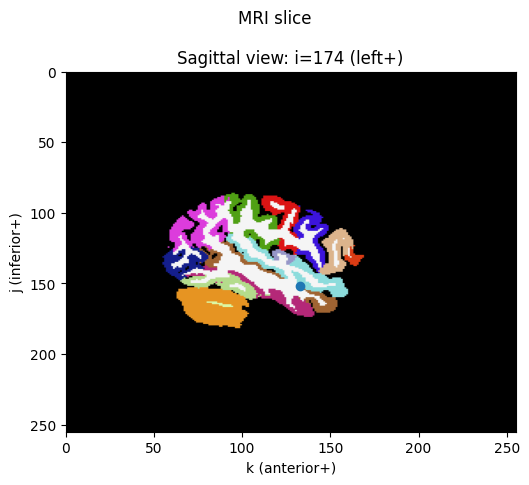

In [118]:
fig = imshow_label_map(data_label, parc_obj, vox, 'MRI slice', cmap='viridis')
fig.axes[0].scatter(vox[2], vox[1])

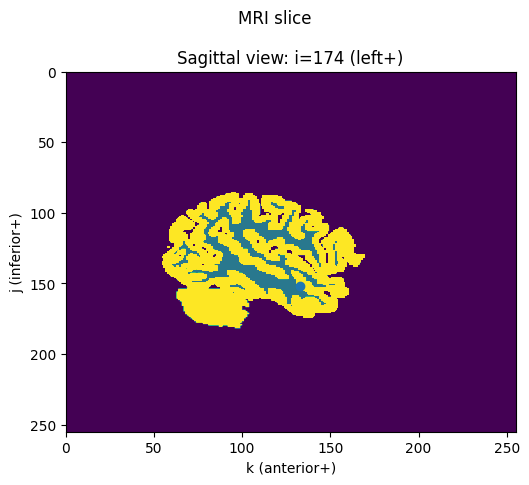

In [124]:
fig = imshow_mri(data_parc, parc_obj, vox, 'MRI slice', cmap='viridis', vmin=0, vmax=5)
fig.axes[0].scatter(vox[2], vox[1])